In [10]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
from scipy.signal import butter, filtfilt, welch, spectrogram
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

# Data preprocessing, filtering, and segmentation
- We capture our EEG data as a pandas pickle object, from which we extract numpy arrays for both time stamps and eeg data.

In [11]:
# original_eeg_df = pd.read_csv("./241207_seizure_KCNA_long1.dat")
# eeg_df = original_eeg_df[["EEG", "Max_Time"]]
# filename = 'cached_EEG.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(eeg_df, file)

# print(f"EEG DF saved to {filename}")

In [12]:
with open('cached_EEG.pkl', 'rb') as f:
    eeg_df = pickle.load(f)

In [13]:
eeg_df.head(5)

,EEG,Max_Time
0,0.0,0.000
1,5987.1,1.953
2,5966.0,3.906
3,5950.1,5.859
4,5922.5,7.812


In [14]:
eeg_signal = eeg_df['EEG'].to_numpy()
time_stamps = eeg_df['Max_Time'].to_numpy()

- We preprocess the data to remove all other interferances (such as muscle twitches), by running a high pass filter to exclude all frequencies below 1Hz

In [15]:
SAMPLING_FS = 512
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

filtered_signal = highpass_filter(eeg_signal, 1, SAMPLING_FS)

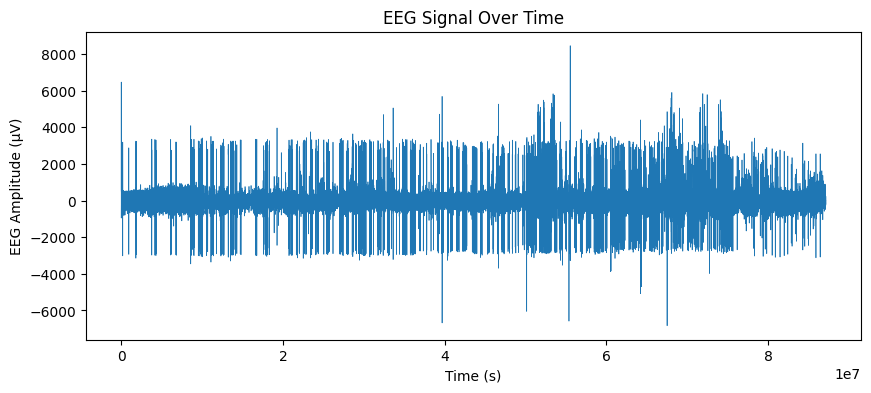

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(time_stamps, filtered_signal, linewidth=0.5)  # Convert ms to seconds for readability
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal Over Time")
plt.show()

- To make our data easier to process and analyze at smaller time-intervals (to narrow down the precise point in time that a seizure occurs), we segment the data into 5 second intervals, with an overlap of around half a second.

In [17]:
SEGMENTATION_LENGTH = 2560
NUM_SAMPLES = len(filtered_signal)
TRIMMED_LENGTH = NUM_SAMPLES % SEGMENTATION_LENGTH
NUMBER_OF_SEGMENTATIONS = NUM_SAMPLES // SEGMENTATION_LENGTH
trimmed_signal = filtered_signal[TRIMMED_LENGTH:]
trimmed_time_stamps = time_stamps[TRIMMED_LENGTH:]
np.shape(trimmed_signal)

(44620800,)

In [18]:
trimmed_time_stamps[44620799]

87154060.547

In [19]:
SEGMENTATION_LENGTH = 2560  # Length of each segment
OVERLAP = 0.1 # Overlap fraction (e.g., 50% overlap)
STEP_SIZE = int(SEGMENTATION_LENGTH * (1 - OVERLAP))  # Step size for sliding window


total_samples = len(trimmed_signal)
NUMBER_OF_SEGMENTATIONS = (total_samples - SEGMENTATION_LENGTH) // STEP_SIZE + 1

# Create segmented arrays with overlap
segmented_signal = np.array([
    trimmed_signal[i : i + SEGMENTATION_LENGTH] 
    for i in range(0, total_samples - SEGMENTATION_LENGTH + 1, STEP_SIZE)
])

segmented_time_stamps = np.array([
    trimmed_time_stamps[i : i + SEGMENTATION_LENGTH] 
    for i in range(0, total_samples - SEGMENTATION_LENGTH + 1, STEP_SIZE)
])

print(segmented_signal.shape)  # (num_segments, SEGMENTATION_LENGTH)
print(segmented_time_stamps.shape)  # (num_segments, SEGMENTATION_LENGTH)


(19366, 2560)
(19366, 2560)


Text(0.5, 1.0, 'EEG Signal Over Time')

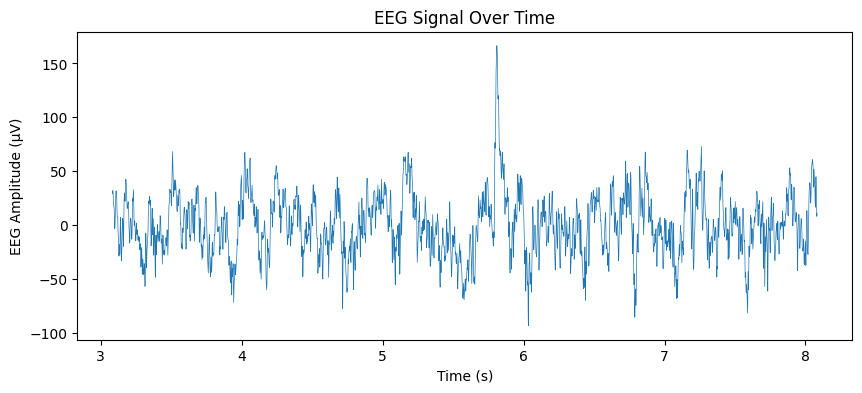

In [20]:
# We plot an example of a segmented piece of data
plt.figure(figsize=(10, 4))
plt.plot(segmented_time_stamps[0] / 1000, segmented_signal[0], linewidth=0.5)  # Convert ms to seconds for readability
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal Over Time")
##plt.show()

# Features Extraction for Learning Algorithm
- We employ signal processing techniques to extract several key features of our signal to be processed by some learning algorithm to categorize seizure events.
- There are three main types of features we may capture:
    - Time-domain features (e.g., amplitude, variance, energy)
    - Frequency-domain features (e.g., power spectral density on frequency bands using Fourier Transform)
    - Time-frequency features (e.g., wavelet transform for analyzing transient events)

In [21]:
SAMPLE_INDEX = 1000
TEST_SEGMENT = segmented_signal[SAMPLE_INDEX]
TEST_TIME_STAMPS = segmented_time_stamps[SAMPLE_INDEX]

## Time-domain features
- We have the following features to calculate per segmentation:  
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Mean</td>
        <td>Average amplitude of EEG segment</td>
    </tr>
    <tr>
        <td>Variance</td>
        <td>Measures EEG signal dispersion</td>
    </tr>
    <tr>
        <td>Standard Deviation</td>
        <td>Spread of EEG values</td>
    </tr>
    <tr>
        <td>Kurtosis</td>
        <td>Measures peak sharpness of EEG segment</td>
    </tr>
    <tr>
        <td>Skewness</td>
        <td>Asymmetry of signal distribution</td>
    </tr>
    <tr>
        <td>Energy</td>
        <td>Sum of squared amplitudes</td>
    </tr>
    <tr>
        <td>Root Mean Square</td>
        <td>Measures overall amplitude strength</td>
    </tr>
    <tr>
        <td>Entropy</td>
        <td>Measures randomness</td>
    </tr>
    <tr>
        <td>Zero-crossing Rate</td>
        <td>Measures oscillation of amplitude</td>
    </tr>
</table>


In [22]:
TEST_SEGMENT

array([-35.65571799, -25.90730467, -11.9568824 , ...,   2.64029691,
        13.63709747,  13.3340581 ])

In [23]:
def compute_time_domain_features(eeg_signal):
    features = {}
    
    # Basic Statistical Features
    features["Mean"] = np.mean(eeg_signal)
    features["Variance"] = np.var(eeg_signal)
    features["Standard_Deviation"] = np.std(eeg_signal)
    features["Kurtosis"] = stats.kurtosis(eeg_signal)
    features["Skewness"] = stats.skew(eeg_signal)
    
    # Energy & Power Features
    features["Energy"] = np.sum(np.square(eeg_signal))
    features["RMS"] = np.sqrt(np.mean(np.square(eeg_signal)))
    
    # Entropy (Shannon Entropy)
    probability_distribution = np.histogram(eeg_signal, bins=10, density=True)[0]
    probability_distribution = probability_distribution[probability_distribution > 0]  # Avoid log(0)
    features["Entropy"] = -np.sum(probability_distribution * np.log2(probability_distribution))

    # ZCR (Zero Crossing Rate)
    zero_crossings = np.where(np.diff(np.sign(eeg_signal)))[0]
    features["Zero_Crossing_Rate"] = len(zero_crossings) / len(eeg_signal)
    
    return features

time_features = compute_time_domain_features(TEST_SEGMENT)
print("Extracted Time-Domain Features:")
for key, value in time_features.items():
    print(f"{key}: {value:.4f}")

Extracted Time-Domain Features:
Mean: 0.1178
Variance: 1779.2380
Standard_Deviation: 42.1810
Kurtosis: 6.3981
Skewness: 1.2693
Energy: 4554884.7310
RMS: 42.1812
Entropy: 0.2015
Zero_Crossing_Rate: 0.1012


## Frequency-Domain Features
- We have the following frequency-domain features to capture for each segmentation
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Peak Frequency</td>
        <td>Frequency with the highest power</td>
    </tr>
    <tr>
        <td>Spectral Entropy</td>
        <td>Measures disorder in the power spectrum</td>
    </tr>
    <tr>
        <td>Mean Frequency</td>
        <td>Weighted average of frequency components</td>
    </tr>
    <tr>
        <td>Power in Frequency Bands</td>
        <td>Power in Delta, Theta, Alpha, Beta, and Gamma bands</td>
    </tr>
</table>

- This is the Welch PSD of our test eeg segment


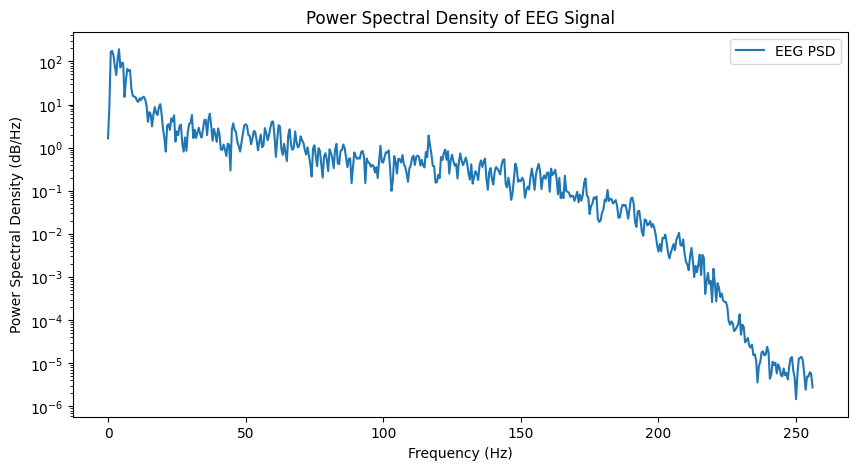

In [24]:
def compute_psd(data, fs):
    f, psd = welch(data, fs, nperseg=fs*2)
    return f, psd

f, psd_raw = compute_psd(TEST_SEGMENT, SAMPLING_FS)
plt.figure(figsize=(10,5))
plt.semilogy(f, psd_raw, label="EEG PSD")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB/Hz)")
plt.title("Power Spectral Density of EEG Signal")
plt.legend()
plt.show()

- We now compute some of our frequency domain features:

In [25]:
def compute_frequency_features(eeg_signal, fs):
    features = {}

    # Compute Power Spectral Density (PSD) using Welch’s method
    f, psd = welch(eeg_signal, fs, nperseg=fs*2)

    # Peak Frequency (Highest Power)
    peak_freq = f[np.argmax(psd)]
    features["Peak_Frequency"] = peak_freq

    # Mean Frequency (Weighted Average)
    mean_freq = np.sum(f * psd) / np.sum(psd)
    features["Mean_Frequency"] = mean_freq

    # Spectral Entropy (Normalized Shannon Entropy of PSD)
    psd_norm = psd / np.sum(psd)  # Normalize PSD
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + 1e-10))  # Avoid log(0)
    features["Spectral_Entropy"] = spectral_entropy

    return features

frequency_features = compute_frequency_features(TEST_SEGMENT, SAMPLING_FS)

# Print extracted features
print("Extracted Frequency-Domain Features:")
for key, value in frequency_features.items():
    print(f"{key}: {value:.4f}")

Extracted Frequency-Domain Features:
Peak_Frequency: 4.0000
Mean_Frequency: 13.9769
Spectral_Entropy: 5.5541


### EEG Frequency Band Decomposition
- From what I have gathered, the following frequency bands correlate to different brain waves in rodents:
    - Delta (0.5–4 Hz) → Deep sleep, unconscious states
    - Theta (4–8 Hz) → Drowsiness, early seizure activity
    - Alpha (8–13 Hz) → Relaxed wakefulness
    - Beta (13–30 Hz) → Active thinking, alertness
    - Gamma (30–100 Hz) → High-frequency oscillations, seizure biomarkers.
- We can perform a bandpass filter on each frequency band and then analyze the power of each band using Welch's method.

In [26]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [27]:
delta_band = bandpass_filter(TEST_SEGMENT, 0.5, 4, 512)
theta_band = bandpass_filter(TEST_SEGMENT, 4, 8, 512)
alpha_band = bandpass_filter(TEST_SEGMENT, 8, 13, 512)
beta_band = bandpass_filter(TEST_SEGMENT, 13, 30, 512)
gamma_band = bandpass_filter(TEST_SEGMENT, 30, 100, 512)

frequency_bands = [delta_band, theta_band, alpha_band, beta_band, gamma_band]

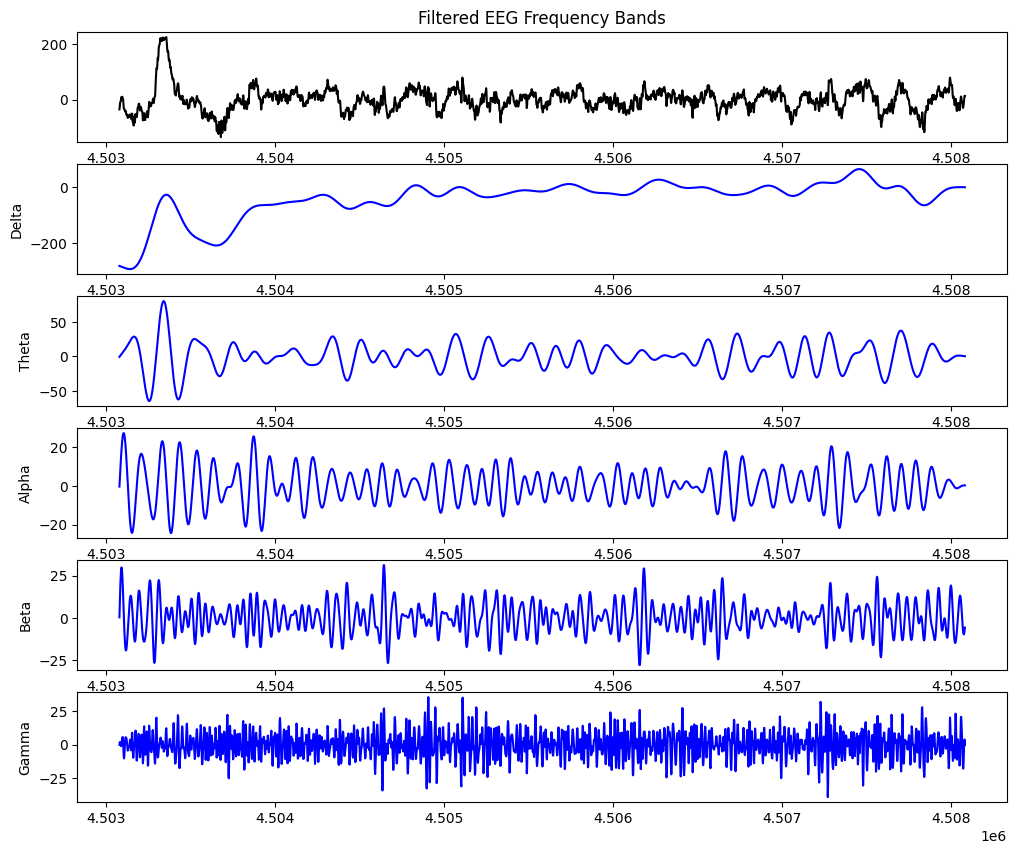

In [28]:
FREQUENCY_BAND_MAPPING = {
    0 : "Delta",
    1 : "Theta",
    2 : "Alpha",
    3 : "Beta",
    4 : "Gamma"
}


plt.figure(figsize=(12,10))
plt.subplot(6, 1, 1)
plt.plot(TEST_TIME_STAMPS, TEST_SEGMENT, label="Raw EEG", color='black')
plt.xlabel("Time (s)")
plt.title("Filtered EEG Frequency Bands")
for i in range(2, 7):
    plt.subplot(6, 1, i)
    plt.plot(TEST_TIME_STAMPS, frequency_bands[i-2], color='blue')
    plt.ylabel(FREQUENCY_BAND_MAPPING[i-2])


plt.show()

- Now we could compute the power of each frequency band and use that as a feature for whatever learning model that we create.

- Finally, computing the power of each frequency band:
    - We do this by taking the integral of the PSD over each specified frequency interval

In [29]:
def compute_band_power(psd, f, low, high):
    idx_band = np.logical_and(f >= low, f <= high)
    return np.trapz(psd[idx_band], f[idx_band])

delta_power = compute_band_power(psd_raw, f, 0.5, 4)
theta_power = compute_band_power(psd_raw, f, 4, 8)
alpha_power = compute_band_power(psd_raw, f, 8, 13)
beta_power = compute_band_power(psd_raw, f, 13, 30)
gamma_power = compute_band_power(psd_raw, f, 30, 100)

band_powers = {
    "Delta (0.5-4 Hz)": delta_power,
    "Theta (4-8 Hz)": theta_power,
    "Alpha (8-13 Hz)": alpha_power,
    "Beta (13-30 Hz)": beta_power,
    "Gamma (30-100 Hz)": gamma_power,
}

print("EEG Band Power:")
for band, power in band_powers.items():
    print(f"{band}: {power:.4f}")

EEG Band Power:
Delta (0.5-4 Hz): 408.7033
Theta (4-8 Hz): 281.1595
Alpha (8-13 Hz): 86.8017
Beta (13-30 Hz): 77.6083
Gamma (30-100 Hz): 101.5859


## Time-Frequency Features
- I don't really understand how some of this more advanced signal processing works, but I've narrowed down my search for features into three key Time-Frequency Features
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Short-Time Fourier Transform</td>
        <td>Tracks frequency variations over time</td>
    </tr>
    <tr>
        <td>Wavelet Transform</td>
        <td>Captures time-localized frequency patterns</td>
    </tr>
    <tr>
        <td>Hilbert Transform</td>
        <td>Spread of EEG values</td>
    </tr>
</table>

- I will be excluding hilbert transform for now, as I do not fully understand what it really does for the signal.

## Short-Time Fourier Transform

- The following is some code I've copied from my EECS16A lab on how to perform stft on a short clip of data. Nothing too exciting happend in the data we extracted.

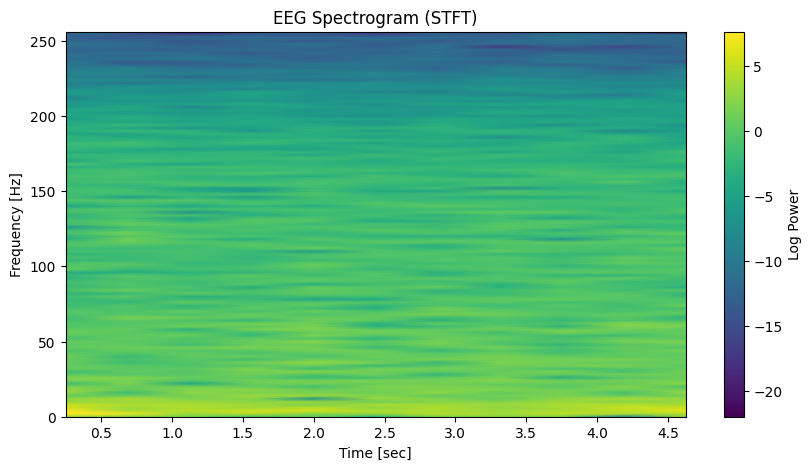

In [30]:
def compute_stft(eeg_signal, fs):
    f, t, Sxx = spectrogram(eeg_signal, fs, nperseg=fs//2)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, np.log(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("EEG Spectrogram (STFT)")
    plt.colorbar(label="Log Power")
    plt.show()
    
    return f, t, Sxx

f, t, Sxx = compute_stft(TEST_SEGMENT, SAMPLING_FS)

- For STFT, we may extract the following data:
<table>
    <tr>
        <th>Feature</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>Spectral Centroid</td>
        <td>Weighted mean of frequencies</td>
    </tr>
    <tr>
        <td>Spectral Bandwidth</td>
        <td>Spread of frequencies around the centroid</td>
    </tr>
    <tr>
        <td>Spectral Entropy</td>
        <td>Disorder in the spectrogram</td>
    </tr>
    <tr>
        <td>Spectral Flatness</td>
        <td>Tonality/Noisyness of the signal</td>
    </tr>
    <tr>
        <td>Spectrogram Energy</td>
        <td>Total energy in time-frequency domain</td>
    </tr>
</table>

In [31]:
import numpy as np
import scipy.signal as signal
import scipy.stats as stats

def extract_stft_features(eeg_signal, fs):
    f, t, Sxx = signal.spectrogram(eeg_signal, fs, nperseg=fs//2)

    # Normalize spectrogram to avoid numerical issues
    Sxx = np.abs(Sxx) + 1e-10  # Avoid log(0) issues

    features = {}

    # Spectral Centroid (Weighted mean of frequencies)
    spectral_centroid = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
    features["Spectral_Centroid_Mean"] = np.mean(spectral_centroid)
    features["Spectral_Centroid_Std"] = np.std(spectral_centroid)

    # Spectral Bandwidth (Variance around centroid)
    spectral_bandwidth = np.sqrt(np.sum(((f[:, None] - spectral_centroid[None, :])**2) * Sxx, axis=0) / np.sum(Sxx, axis=0))
    features["Spectral_Bandwidth_Mean"] = np.mean(spectral_bandwidth)
    features["Spectral_Bandwidth_Std"] = np.std(spectral_bandwidth)

    # Spectral Entropy (Shannon entropy over time)
    Sxx_norm = Sxx / np.sum(Sxx, axis=0)  # Normalize
    spectral_entropy = -np.sum(Sxx_norm * np.log2(Sxx_norm + 1e-10), axis=0)
    features["Spectral_Entropy_Mean"] = np.mean(spectral_entropy)
    features["Spectral_Entropy_Std"] = np.std(spectral_entropy)

    # Spectral Flatness (Ratio of geometric mean to arithmetic mean)
    spectral_flatness = np.exp(np.mean(np.log(Sxx + 1e-10), axis=0)) / np.mean(Sxx, axis=0)
    features["Spectral_Flatness_Mean"] = np.mean(spectral_flatness)
    features["Spectral_Flatness_Std"] = np.std(spectral_flatness)

    # Total Energy in Spectrogram
    features["Spectrogram_Total_Energy"] = np.sum(Sxx)

    return features

stft_features = extract_stft_features(TEST_SEGMENT, SAMPLING_FS)

print("Extracted STFT-Based Features:")
for key, value in stft_features.items():
    print(f"{key}: {value:.4f}")


Extracted STFT-Based Features:
Spectral_Centroid_Mean: 15.3220
Spectral_Centroid_Std: 6.1095
Spectral_Bandwidth_Mean: 24.8696
Spectral_Bandwidth_Std: 6.6286
Spectral_Entropy_Mean: 3.3745
Spectral_Entropy_Std: 0.8815
Spectral_Flatness_Mean: 0.0167
Spectral_Flatness_Std: 0.0090
Spectrogram_Total_Energy: 9293.6020


## DWT Decomposition
- I have found two Wavelet decomposition methods, a continuous wavelet transform that uses morlet wavlets, and a discrete wavelet transform that uses daubauchies wavelets.
    - A research into the two options reveals that the CWT is more accurate, but a lot more computationally intensive than a DWT approach, which I believe should be sufficient for our analysis.
- This is the CWT approach:

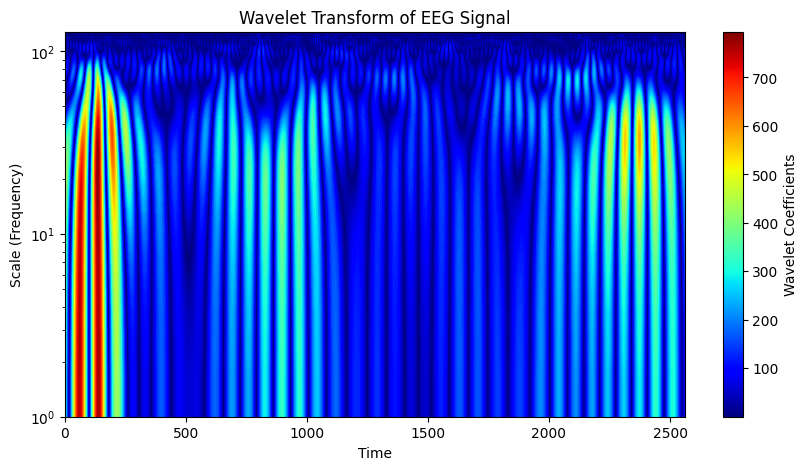

In [32]:
import pywt

def compute_CWT_transform(eeg_signal, wavelet='morl'):
    scales = np.arange(1, 128)  # Define scales for wavelet transform
    coefs, frequencies = pywt.cwt(eeg_signal, scales, wavelet)

    plt.figure(figsize=(10, 5))
    plt.imshow(np.abs(coefs), aspect='auto', cmap='jet', extent=[0, len(eeg_signal), 1, 128])
    plt.yscale("log")
    plt.colorbar(label="Wavelet Coefficients")
    plt.xlabel("Time")
    plt.ylabel("Scale (Frequency)")
    plt.title("Wavelet Transform of EEG Signal")
    plt.show()
    
    return coefs, frequencies

# Example usage:
coefs, frequencies = compute_CWT_transform(TEST_SEGMENT)


- This is the DWT approach

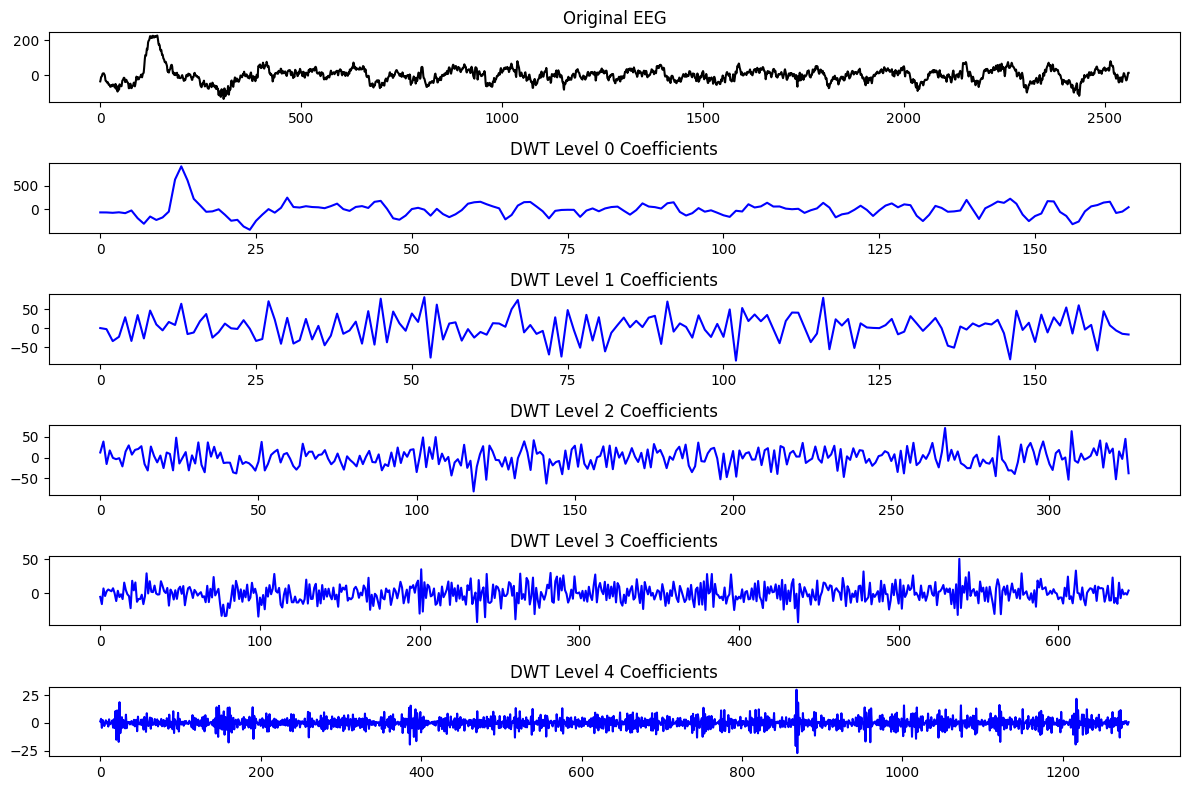

In [33]:
def compute_dwt(eeg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)

    # Plot Approximation and Detail Coefficients
    plt.figure(figsize=(12, 8))
    plt.subplot(len(coeffs)+1, 1, 1)
    plt.plot(eeg_signal, color='black')
    plt.title("Original EEG")
    for i, coef in enumerate(coeffs):
        plt.subplot(len(coeffs)+1, 1, i+2)
        plt.plot(coef, color='blue')
        plt.title(f"DWT Level {i} Coefficients")
    plt.tight_layout()
    plt.show()

    return coeffs

# Example usage:
dwt_coeffs = compute_dwt(TEST_SEGMENT)

- Now we may try to extract features from the DWT approach. We will be focusing on basic statistical features, energy, as well as entropy.
    - I believe that high wavelet energy (particularly in DWT level 4 and level 3, which are D1 and D2 coefficients respectively), may correlate to seizure activity.
    - I also believe that increased Wavelet Entropy may indicate the EEG data getting more "choatic" during seizures.

In [34]:
def extract_wavelet_features(eeg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)
    
    features = {}
    
    for i, coef in enumerate(coeffs):
        # Statistical features
        features[f"Wavelet_Mean_L{i}"] = np.mean(coef)
        features[f"Wavelet_Variance_L{i}"] = np.var(coef)
        features[f"Wavelet_Skewness_L{i}"] = stats.skew(coef)
        features[f"Wavelet_Kurtosis_L{i}"] = stats.kurtosis(coef)
        
        # Energy of wavelet coefficients
        features[f"Wavelet_Energy_L{i}"] = np.sum(np.square(coef))
        
        # Entropy of wavelet coefficients
        coef_prob = np.abs(coef) / np.sum(np.abs(coef))  # Normalize
        features[f"Wavelet_Entropy_L{i}"] = -np.sum(coef_prob * np.log2(coef_prob + 1e-10))  # Shannon Entropy
    
    return features

# Example usage:
wavelet_features = extract_wavelet_features(TEST_SEGMENT)
print("Extracted Wavelet-Based Features:")
for key, value in wavelet_features.items():
    print(f"{key}: {value:.4f}")

Extracted Wavelet-Based Features:
Wavelet_Mean_L0: -1.2912
Wavelet_Variance_L0: 24608.3072
Wavelet_Skewness_L0: 1.5610
Wavelet_Kurtosis_L0: 8.2177
Wavelet_Energy_L0: 4085255.7429
Wavelet_Entropy_L0: 6.7908
Wavelet_Mean_L1: 2.3481
Wavelet_Variance_L1: 1113.9804
Wavelet_Skewness_L1: -0.1145
Wavelet_Kurtosis_L1: 0.0126
Wavelet_Energy_L1: 185836.0105
Wavelet_Entropy_L1: 6.9266
Wavelet_Mean_L2: -0.7818
Wavelet_Variance_L2: 517.1609
Wavelet_Skewness_L2: -0.0919
Wavelet_Kurtosis_L2: 0.1703
Wavelet_Energy_L2: 168793.7321
Wavelet_Entropy_L2: 7.9538
Wavelet_Mean_L3: -0.3923
Wavelet_Variance_L3: 165.1201
Wavelet_Skewness_L3: -0.0153
Wavelet_Kurtosis_L3: 0.4447
Wavelet_Energy_L3: 106601.7520
Wavelet_Entropy_L3: 8.9250
Wavelet_Mean_L4: 0.0030
Wavelet_Variance_L4: 30.2491
Wavelet_Skewness_L4: 0.0318
Wavelet_Kurtosis_L4: 1.8760
Wavelet_Energy_L4: 38809.6641
Wavelet_Entropy_L4: 9.8404


# Aggregating Feature and Data for Model Training
- We now calculate all features for each data segment and classify each segment as a seizure/non-seizure to construct a dataset for training.

In [35]:
annotations = pd.read_excel("./zqm_annotation_seizure.xlsx", sheet_name="KCNA_1207")

Drop all NaN entries

In [36]:
annotations = annotations[['Start', 'End']].map(lambda x: 60*1000*x)
annotations = annotations.dropna()
annotations

,Start,End
0,2.974651e+05,4.793214e+05
1,6.663737e+05,7.339203e+05
2,8.144480e+05,8.441010e+05
3,8.491191e+05,8.655423e+05
4,8.910895e+05,9.864351e+05
...,...,...
605,8.519699e+07,8.520875e+07
606,8.522746e+07,8.523441e+07
607,8.525376e+07,8.526285e+07
608,8.532753e+07,8.533341e+07


Zip all features and labels into a datset

In [37]:
feature_rows = []

def check_seizure_overlap(segment_start, segment_end, annotations):
    for _, row in annotations.iterrows():
        seizure_start = row["Start"]
        seizure_end = row["End"]
        if (seizure_start <= segment_start <= seizure_end) or (seizure_start <= segment_end <= seizure_end):
            return 1

    return 0

for segment in tqdm(segmented_time_stamps, desc="Extracting Features", unit="segment"):
    segment_start = segment[0]
    segment_end = segment[-1]

    # Extract features
    time_features = compute_time_domain_features(segment)
    frequency_features = compute_frequency_features(segment, SAMPLING_FS)
    f, psd_raw = compute_psd(segment, SAMPLING_FS)
    band_powers = {
        "Delta_BandPower": compute_band_power(psd_raw, f, 0.5, 4),
        "Theta_BandPower": compute_band_power(psd_raw, f, 4, 8),
        "Alpha_BandPower": compute_band_power(psd_raw, f, 8, 13),
        "Beta_BandPower": compute_band_power(psd_raw, f, 13, 30),
        "Gamma_BandPower": compute_band_power(psd_raw, f, 30, 100),
    }
    stft_features = extract_stft_features(segment, SAMPLING_FS)
    wavelet_features = extract_wavelet_features(segment)

    is_seizure = check_seizure_overlap(segment_start, segment_end, annotations)

    # Merge all feature dictionaries into a single row
    row_features = {
        "Segment_Start": segment_start,
        "Segment_End": segment_end,
        **time_features,
        **frequency_features,
        **band_powers,
        **stft_features,
        **wavelet_features,
        "Label": is_seizure  # This is what we use to train our SVM
    }

    feature_rows.append(row_features)

# Convert list of dictionaries into a DataFrame
features_df = pd.DataFrame(feature_rows)

Extracting Features: 100%|██████████| 19366/19366 [11:26<00:00, 28.19segment/s]


In [38]:
features_df

,Segment_Start,Segment_End,Mean,Variance,Standard_Deviation,Kurtosis,Skewness,Energy,RMS,Entropy,...,Wavelet_Kurtosis_L3,Wavelet_Energy_L3,Wavelet_Entropy_L3,Wavelet_Mean_L4,Wavelet_Variance_L4,Wavelet_Skewness_L4,Wavelet_Kurtosis_L4,Wavelet_Energy_L4,Wavelet_Entropy_L4,Label
0,3.083984e+03,8.082031e+03,5.583008e+03,2.083333e+06,1443.375562,-1.2,1.189178e-12,8.512847e+10,5.766568e+03,0.024584,...,145.694177,15.743910,2.976044,9.600598e-08,0.000038,-0.011513,317.276540,0.049019,5.098697,0
1,7.583984e+03,1.258203e+04,1.008301e+04,2.083333e+06,1443.375562,-1.2,1.189051e-12,2.656010e+11,1.018579e+04,0.024584,...,145.694177,15.743910,2.976044,9.600603e-08,0.000038,-0.011513,317.276540,0.049019,5.098697,0
2,1.208398e+04,1.708203e+04,1.458301e+04,2.083333e+06,1443.375562,-1.2,1.189051e-12,5.497535e+11,1.465426e+04,0.024584,...,145.694177,15.743910,2.976044,9.600607e-08,0.000038,-0.011513,317.276540,0.049019,5.098697,0
3,1.658398e+04,2.158203e+04,1.908301e+04,2.083333e+06,1443.375562,-1.2,1.189051e-12,9.375860e+11,1.913752e+04,0.024584,...,145.694177,15.743910,2.976044,9.600613e-08,0.000038,-0.011513,317.276540,0.049019,5.098697,0
4,2.108398e+04,2.608203e+04,2.358301e+04,2.083333e+06,1443.375562,-1.2,1.189051e-12,1.429098e+12,2.362714e+04,0.024584,...,145.694177,15.743910,2.976044,9.600619e-08,0.000038,-0.011513,317.276540,0.049019,5.098697,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19361,8.712856e+07,8.713356e+07,8.713106e+07,2.083333e+06,1443.375564,-1.2,2.140749e-12,1.943506e+19,8.713106e+07,0.024584,...,145.674680,15.735069,2.869414,-3.847888e-07,0.000038,-0.111882,316.844987,0.048984,5.100625,0
19362,8.713306e+07,8.713806e+07,8.713556e+07,2.083333e+06,1443.375564,-1.2,2.140749e-12,1.943707e+19,8.713556e+07,0.024584,...,145.674680,15.735069,2.869415,-3.846821e-07,0.000038,-0.111881,316.844992,0.048984,5.100630,0
19363,8.713756e+07,8.714256e+07,8.714006e+07,2.083333e+06,1443.375564,-1.2,2.140749e-12,1.943908e+19,8.714006e+07,0.024584,...,145.674681,15.735069,2.869414,-3.848057e-07,0.000038,-0.111880,316.844999,0.048984,5.100633,0
19364,8.714206e+07,8.714706e+07,8.714456e+07,2.083333e+06,1443.375564,-1.2,2.140749e-12,1.944109e+19,8.714456e+07,0.024584,...,145.674681,15.735069,2.869415,-3.849810e-07,0.000038,-0.111881,316.845007,0.048984,5.100627,0


In [39]:
filename = 'features_dataset.pkl'
with open(filename, 'wb') as file:
    pickle.dump(features_df, file)

print(f"Data saved to {filename}")

Data saved to features_dataset.pkl


## Dataset Preprocessing
- To optimize our model for SVM, a couple preprocessing steps must be applied:
    1. Feature Normalization
    2. Feature Selection
    3. Class Imbalance ? (If there are too many non-seizures vs seizures)

### Feature Normalization

In [40]:
features = features_df.drop(columns=["Label", "Segment_Start", "Segment_End"])

# Apply Standardization (mean=0, variance=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert back to DataFrame
scaled_features_df = pd.DataFrame(features_scaled, columns=features.columns)

# Add labels back
scaled_features_df["Label"], scaled_features_df["Segment_Start"], scaled_features_df["Segment_End"] = features_df["Label"], features_df["Segment_Start"], features_df["Segment_End"]
scaled_features_df


,Mean,Variance,Standard_Deviation,Kurtosis,Skewness,Energy,RMS,Entropy,Zero_Crossing_Rate,Peak_Frequency,...,Wavelet_Entropy_L3,Wavelet_Mean_L4,Wavelet_Variance_L4,Wavelet_Skewness_L4,Wavelet_Kurtosis_L4,Wavelet_Energy_L4,Wavelet_Entropy_L4,Label,Segment_Start,Segment_End
0,-1.731952,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731945,0.012263,0.0,0.0,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,3.083984e+03,8.082031e+03
1,-1.731774,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731769,0.012263,0.0,0.0,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,7.583984e+03,1.258203e+04
2,-1.731595,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731592,0.012263,0.0,0.0,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,1.208398e+04,1.708203e+04
3,-1.731416,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731414,0.012263,0.0,0.0,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,1.658398e+04,2.158203e+04
4,-1.731237,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731235,0.012263,0.0,0.0,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,2.108398e+04,2.608203e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19361,1.731242,-0.012136,-0.012273,0.008552,0.002776,2.234470,1.731242,0.012263,0.0,0.0,...,-1.288529,-0.009876,-0.009754,-0.064596,-0.066680,-0.009754,0.081665,0,8.712856e+07,8.713356e+07
19362,1.731421,-0.012136,-0.012273,0.008552,0.002776,2.234817,1.731421,0.012263,0.0,0.0,...,-1.288526,-0.009876,-0.009754,-0.064596,-0.066680,-0.009754,0.081706,0,8.713306e+07,8.713806e+07
19363,1.731600,-0.012136,-0.012273,0.008552,0.002776,2.235163,1.731600,0.012263,0.0,0.0,...,-1.288533,-0.009876,-0.009754,-0.064595,-0.066680,-0.009754,0.081735,0,8.713756e+07,8.714256e+07
19364,1.731779,-0.012136,-0.012273,0.008552,0.002776,2.235509,1.731779,0.012263,0.0,0.0,...,-1.288527,-0.009876,-0.009754,-0.064596,-0.066680,-0.009754,0.081679,0,8.714206e+07,8.714706e+07


### Feature Selection
- As we can see, the Zero-Crossing Rate and Peak Frequency were constant values, so they are not much help to our model, and hence removed.

In [41]:
selector = VarianceThreshold(threshold=0.1)  # Removes near-constant features
selected_scaled_features = selector.fit_transform(scaled_features_df.drop(columns=["Label", "Segment_Start", "Segment_End"]))

# Convert back to DataFrame
selected_features = features.columns[selector.get_support()]
selected_scaled_features_df = pd.DataFrame(selected_scaled_features, columns=selected_features)

# Add labels back
selected_scaled_features_df["Label"], selected_scaled_features_df["Segment_Start"], selected_scaled_features_df["Segment_End"] = features_df["Label"], features_df["Segment_Start"], features_df["Segment_End"]
selected_scaled_features_df

,Mean,Variance,Standard_Deviation,Kurtosis,Skewness,Energy,RMS,Entropy,Mean_Frequency,Spectral_Entropy,...,Wavelet_Entropy_L3,Wavelet_Mean_L4,Wavelet_Variance_L4,Wavelet_Skewness_L4,Wavelet_Kurtosis_L4,Wavelet_Energy_L4,Wavelet_Entropy_L4,Label,Segment_Start,Segment_End
0,-1.731952,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731945,0.012263,-0.009689,-0.010376,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,3.083984e+03,8.082031e+03
1,-1.731774,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731769,0.012263,-0.009689,-0.010376,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,7.583984e+03,1.258203e+04
2,-1.731595,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731592,0.012263,-0.009689,-0.010376,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,1.208398e+04,1.708203e+04
3,-1.731416,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731414,0.012263,-0.009689,-0.010376,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,1.658398e+04,2.158203e+04
4,-1.731237,-0.012137,-0.012274,0.008548,0.002776,-1.118078,-1.731235,0.012263,-0.009689,-0.010376,...,0.127298,-0.009447,-0.009754,-0.002060,-0.053171,-0.009754,0.065932,0,2.108398e+04,2.608203e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19361,1.731242,-0.012136,-0.012273,0.008552,0.002776,2.234470,1.731242,0.012263,-0.009689,-0.010376,...,-1.288529,-0.009876,-0.009754,-0.064596,-0.066680,-0.009754,0.081665,0,8.712856e+07,8.713356e+07
19362,1.731421,-0.012136,-0.012273,0.008552,0.002776,2.234817,1.731421,0.012263,-0.009689,-0.010376,...,-1.288526,-0.009876,-0.009754,-0.064596,-0.066680,-0.009754,0.081706,0,8.713306e+07,8.713806e+07
19363,1.731600,-0.012136,-0.012273,0.008552,0.002776,2.235163,1.731600,0.012263,-0.009689,-0.010376,...,-1.288533,-0.009876,-0.009754,-0.064595,-0.066680,-0.009754,0.081735,0,8.713756e+07,8.714256e+07
19364,1.731779,-0.012136,-0.012273,0.008552,0.002776,2.235509,1.731779,0.012263,-0.009689,-0.010376,...,-1.288527,-0.009876,-0.009754,-0.064596,-0.066680,-0.009754,0.081679,0,8.714206e+07,8.714706e+07


### Class Imbalance

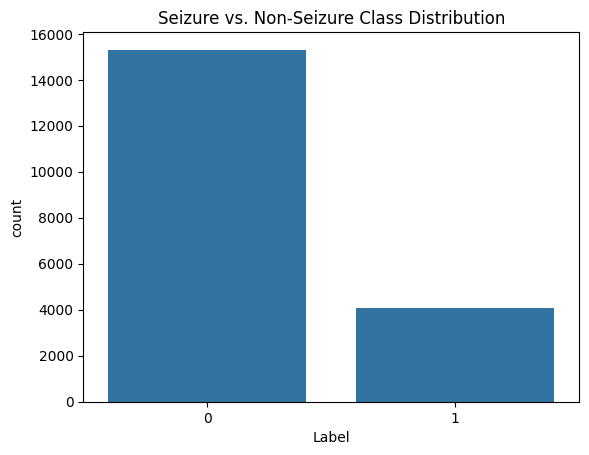

Label
0    0.790458
1    0.209542
Name: proportion, dtype: float64
Imbalance Ratio: 3.77


In [42]:
sns.countplot(x=selected_scaled_features_df["Label"])
plt.title("Seizure vs. Non-Seizure Class Distribution")
plt.show()
print(selected_scaled_features_df["Label"].value_counts(normalize=True))
class_counts = selected_scaled_features_df["Label"].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

# SVM Training and Testing

In [49]:
X = selected_scaled_features_df[['Mean', 'Wavelet_Mean_L2', 'Wavelet_Entropy_L0', 'Wavelet_Energy_L0', 'Wavelet_Mean_L0', 'Alpha_BandPower', 'Entropy', 'Wavelet_Entropy_L4', 'Energy', 'RMS']]
y = selected_scaled_features_df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model
svm_model = SVC(kernel="rbf", class_weight="balanced", C=1, gamma="scale", random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', random_state=42)

Model Accuracy: 0.5958
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.58      0.69      3062
           1       0.29      0.66      0.41       812

    accuracy                           0.60      3874
   macro avg       0.58      0.62      0.55      3874
weighted avg       0.75      0.60      0.63      3874



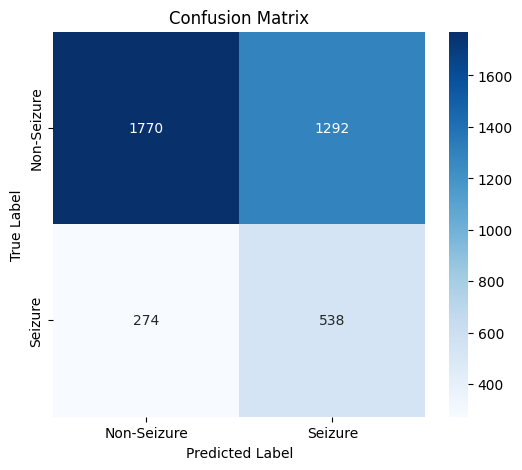

In [50]:
# Predict on test set
y_pred = svm_model.predict(X_test)

# Print Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Seizure", "Seizure"], yticklabels=["Non-Seizure", "Seizure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [47]:
# Use SVM as the base model for RFE
svm = SVC(kernel="linear", class_weight="balanced")

# Perform Recursive Feature Elimination (RFE)
rfe = RFE(svm, n_features_to_select=10)  # Adjust number of top features
rfe.fit(X_train, y_train)

# Get feature rankings
feature_ranks = pd.DataFrame({
    "Feature": X.columns,
    "Rank": rfe.ranking_
}).sort_values(by="Rank", ascending=True)

In [53]:
rfe.ranking_

array([ 1, 31, 27, 19, 10,  1,  1,  1,  6,  4,  3, 35,  1, 16, 30, 18, 17,
       40, 32, 41, 34, 13, 20,  5,  1, 33,  7, 11,  1,  1, 21, 44, 28, 43,
       42, 26,  1, 38, 14,  9, 36, 45, 22, 23, 15, 12, 24, 29, 25, 37,  8,
        2, 39,  1])

In [48]:
feature_ranks

,Feature,Rank
0,Mean,1
36,Wavelet_Mean_L2,1
29,Wavelet_Entropy_L0,1
28,Wavelet_Energy_L0,1
24,Wavelet_Mean_L0,1
12,Alpha_BandPower,1
7,Entropy,1
53,Wavelet_Entropy_L4,1
5,Energy,1
6,RMS,1
